In [2]:
import time
from pathlib import Path

import numpy as np
from numba import njit

from matplotlib import pyplot as plt

### Load data

In [3]:
train_data = np.loadtxt(Path('D:/Development/Data/datasets/csv/mnist_train_small.csv'), delimiter=',')
test_data = np.loadtxt(Path('D:/Development/Data/datasets/csv/mnist_test.csv'), delimiter=',')

In [4]:
x_train = train_data[:,1:] / 255.0
x_test = test_data[:,1:] / 255.0

In [5]:
img_shape = (28, 28)
img_size = 784

### Define activation functions

In [33]:
@njit(fastmath=True)
def ReLU(x: np.ndarray) -> np.ndarray:
    return 1.0 * (x > 0.0)


@njit(fastmath=True)
def dReLU(x: np.ndarray) -> np.ndarray:
    return x * (x > 0.0)


@njit(fastmath=True)
def Sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)

In [34]:
@njit(fastmath=True)
def MSE(x: np.ndarray, x_hat: np.ndarray) -> float:
    return np.mean(np.square(x-x_hat))

### Define model

In [36]:
class Autoencoder:
    def __init__(self, n_in: int, n_h: int) -> None:
        self.U: np.ndarray = np.random.uniform(-1, 1, (n_h, n_in))
        self.d: np.ndarray = np.zeros(n_h)

        self.W: np.ndarray = np.random.uniform(-1, 1, (n_in, n_h))
        self.b: np.ndarray = np.zeros(n_in)
    
    @property
    def parameters(self) -> tuple[np.ndarray]:
        return (self.U, self.d, self.W, self.b)

    def forward(self, x: np.ndarray) -> np.ndarray:
        z = ReLU(self.U @ x + self.d)
        return self.W @ z + self.b


def loss(model: Autoencoder, X: np.ndarray) -> float:        
    X_hat = np.array([model.forward(x) for x in X])
    return np.mean(np.array([MSE(x,x_hat) for (x,x_hat) in zip(X,X_hat)]))

In [48]:
@njit(fastmath=True)
def grads(parameters: tuple[np.ndarray], X: np.ndarray) -> tuple[np.ndarray]:
    U, d, W, b = parameters
    dU, dd = np.zeros(U.shape), np.zeros(d.shape)
    dW, db = np.zeros(W.shape), np.zeros(b.shape)

    for i in range(len(X)):
        h = U @ X[i] + d
        z = ReLU(h)
        x_hat = W @ z + b

        dLdy = 2 * (x_hat - X[i])
        dLdh = W.T @ dLdy * dReLU(h)

        dU += np.outer(dLdh, X[i])
        dd += dLdh

        dW += np.outer(dLdy, z)
        db += dLdy

    return (dU, dd, dW, db)

In [54]:
def train(model: Autoencoder, X: np.ndarray, lr, batch_size, max_epoch) -> None:
    n_samples = len(X)
    n_batches = n_samples // batch_size

    for epoch in range(max_epoch):
        idxs = np.random.permutation(n_samples)
        batches = np.array_split(idxs, n_batches)

        for batch in batches:
            dU, dd, dW, db = grads(model.parameters, X[batch])

            model.U -= lr * dU / batch_size
            model.d -= lr * dd / batch_size
            
            model.W -= lr * dW / batch_size
            model.b -= lr * db / batch_size

### Create and train model

In [51]:
n_in = 784
n_h = 16

learning_rate = 1e-2
batch_size = 64
max_epoch = 4

model = Autoencoder(n_in, n_h)

print(f'untrained loss: {loss(model, x_test)}')
start_t = time.time()

train(model, x_train, learning_rate, batch_size, max_epoch)

print(f'trained loss: {loss(model, x_test)}')
print(f'training time: {round(time.time()-start_t, 2)} sec.')

untrained loss: 2.3334757085729367
trained loss: 0.06902171111040373
training time: 13.03 sec.


### Visualize model's learned features

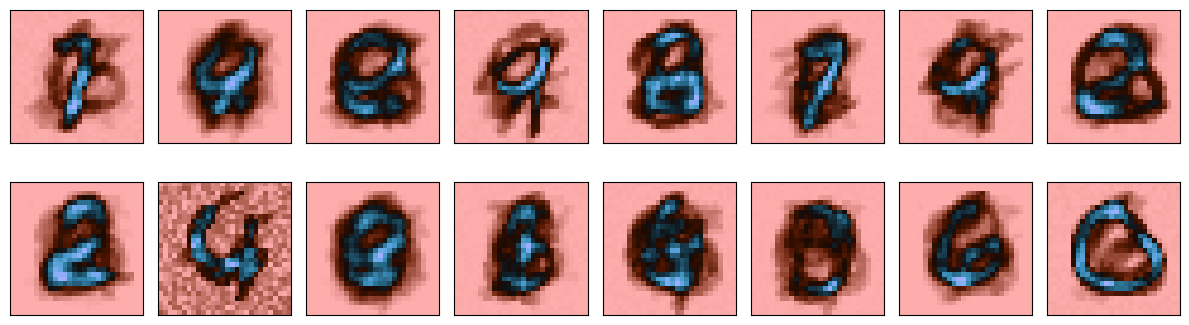

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=8)

fig.set_dpi(100)
fig.set_figheight(4)
fig.set_figwidth(12)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(model.U[i].reshape(img_shape),  cmap='berlin')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

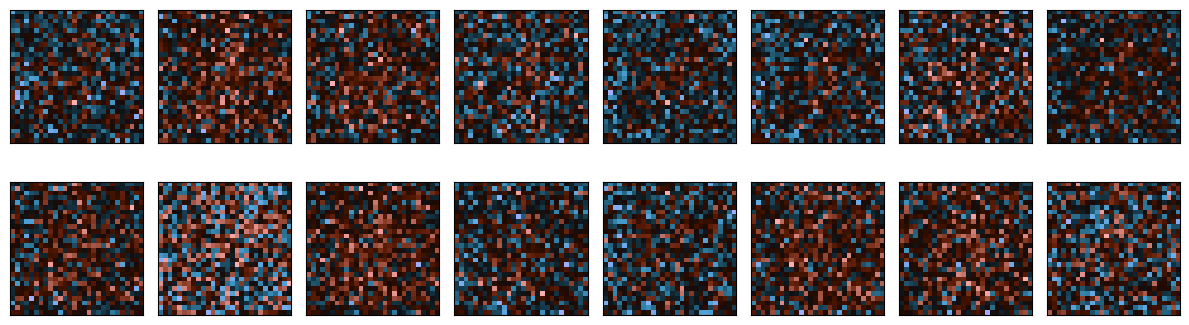

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=8)

fig.set_dpi(100)
fig.set_figheight(4)
fig.set_figwidth(12)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(model.W[:,i].reshape(img_shape),  cmap='berlin')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()